# Notes on creating a generic particles reader/writer class

there's soemthing funky going on with references 

In [1]:
DATADIR = '/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs'

In [2]:
import h5py
import glob
from os import path
import numpy as np
import mrcfile

In [146]:
def parse_particle_star( filepath ):
    with open(filepath, 'r') as f:
        keys = []
        for i in f.readlines():
            if i.startswith('_rln'):
                k = i.split()[0].replace('_rln','')
                keys.append(k)
            else:
                data = i.split()
                if len(data) == len(keys) and len(data) > 0:
                    out = {}
                    for n,k in enumerate(keys):
                        out[k] = data[n]
                        try:
                            if k not in ('ClassNumber',):
                                out[k] = float(data[n])
                        except:
                            pass
#                     print("  %s found: %s" % (i,out,))
                    yield out

def get_particle_image( mrcs ):
    with mrcfile.open(mrcs, permissive=True) as particles:
        # print( particles.data.shape )
        # mrcfile returns just a 2 dimensional matrix if only single image
        if len(particles.data.shape) == 2:
            yield particles.data
        else:
            for p in particles.data:
                yield p

def get_images( file_pattern, star_pattern ):
    for mrc in glob.glob( file_pattern ):
#         print("File: %s" % (mrc,))
        star_file = mrc.replace( *star_pattern )
        md = None
        if path.exists( star_file ):
            md = [ m for m in parse_particle_star( star_file ) ]
#         print(" meta: %s -> %s" % (star_file,len(md)))
        for i, p in enumerate( get_particle_image( mrc ) ):
            yield p, md[i] if md else None

            
def add_metadata( hf, path, meta, key ):
    klass = hf[path]
    klass.resize( (klass.shape[0]+1), axis=0 )
    klass[-klass.shape[0]:] = int(meta['ClassNumber'])
            
def create_particle_stack( output_file, file_pattern='./*.mrcs', star_pattern=('.mrcs', '_extract.star'), group_name='particles', image_name='images', parse_particle_star=True, first=None ):
    with h5py.File(output_file, 'w') as hf:
        string_dt = h5py.special_dtype(vlen=str)
        i = 0
        grp = hf.create_group(group_name)
        for p,meta in get_images( file_pattern, star_pattern ):
            print( " got %s: %s (%s)" % (i,p.shape,meta) )
            if i == 0:
                grp.create_dataset(image_name, data=p[np.newaxis,...], maxshape=(None,p.shape[0],p.shape[1]), chunks=True)
                grp.create_dataset('class', data=np.asarray( [int(meta['ClassNumber']),] ),  maxshape=(None,), chunks=True, dtype='int8' )
                grp.create_dataset('ctf_resolution', data=np.asarray( [meta['CtfMaxResolution'],] ),  maxshape=(None,), chunks=True )
                grp.create_dataset('angle_psi', data=np.asarray( [meta['AnglePsi'],] ),  maxshape=(None,), chunks=True )

                # not working?
                grp.create_dataset('source_micrograph', data=np.array( [meta['MicrographName'],], dtype='S' ), maxshape=(None,), chunks=True, dtype=string_dt )

                grp.create_dataset('source_coordinates', data=np.array( [ ( meta['CoordinateX'], meta['CoordinateY'] ) ] ), maxshape=(None,2), chunks=True )

            else:
#                 print("P: %s" % (p,))
                images = hf['%s/%s' % (group_name,image_name)]
                images.resize( (images.shape[0]+1), axis=0 )
                images[-images.shape[0]:] = p.copy()

                add_metadata( hf, 'particles/class', meta, 'ClassNumber')
                add_metadata( hf, 'particles/ctf_resolution', meta, 'CtfMaxResolution')
                add_metadata( hf, 'particles/angle_psi', meta, 'AnglePsi')                

                add_metadata( hf, 'particles/source_micrograph', meta, 'MicrographName')
                coords = hf['%s/%s' % (group_name,'source_coordinates')]
                coords.resize( (coords.shape[0]+1), axis=0 )
                coords[-coords.shape[0]:] =  [ ( meta['CoordinateX'], meta['CoordinateY'] ) ] 
                
                
#             print("%s" % (hf[image_name].shape,))
            print( ".", end='')
            
            if first and i >= first - 1:
                break
            i = i+1


In [147]:
create_particle_stack( '/tmp/particles.hdf', file_pattern=DATADIR+"/*.mrcs", first=5 )

 got 0: (540, 540) ({'CoordinateX': 1089.63996, 'CoordinateY': 3186.057024, 'AutopickFigureOfMerit': 0.092939, 'ClassNumber': '93', 'AnglePsi': -174.12814, 'ImageName': '000001@Extract/job289/Micrographs/Hasan_01692_aligned_DW.mrcs', 'MicrographName': 'Micrographs/Hasan_01692_aligned_DW.mrc', 'Magnification': 10000.0, 'DetectorPixelSize': 0.683, 'CtfMaxResolution': 3.232297, 'CtfFigureOfMerit': 0.096946, 'Voltage': 300.0, 'DefocusU': 12123.828125, 'DefocusV': 11720.999023, 'DefocusAngle': -66.46259, 'SphericalAberration': 2.7, 'CtfBfactor': 0.0, 'CtfScalefactor': 1.0, 'PhaseShift': 0.0, 'AmplitudeContrast': 0.1, 'OriginX': 0.118616, 'OriginY': 0.126518, 'GroupNumber': 1603.0, 'AngleRot': 0.0, 'AngleTilt': 0.0, 'NormCorrection': 0.843922, 'LogLikeliContribution': 75155.385834, 'MaxValueProbDistribution': 1.0, 'NrOfSignificantSamples': 3.0})
. got 1: (540, 540) ({'CoordinateX': 2839.085608, 'CoordinateY': 236.38285, 'AutopickFigureOfMerit': 0.092054, 'ClassNumber': '93', 'AnglePsi': -61.

hmmm... all the images are the same... even though i'm using p.copy() above...

<HDF5 dataset "images": shape (5, 540, 540), type "<f4">
Particle #0: class 93 from 93@[ 571.148549 2503.182764] 
[[-1.6703042   0.04279047  1.1082757  ...  1.1201062  -1.0580032
  -0.18329015]
 [-1.3252518  -0.5656686   0.50778794 ...  1.8512449  -0.5306258
  -0.36595204]
 [-1.1735461  -0.89015764  0.26884112 ...  1.4333687  -0.44683903
  -0.42583343]
 ...
 [-0.9653343   0.10381357  0.25659594 ... -0.23840512 -1.089901
   0.7021539 ]
 [ 0.38384575  0.3199892  -0.08682799 ...  0.5943302  -0.0815199
   0.96424836]
 [ 0.8728238   1.2109184   0.30578512 ...  0.2631717   1.7938929
   2.07715   ]] 
Particle #1: class 93 from 93@[ 571.148549 2503.182764] 
[[-1.6703042   0.04279047  1.1082757  ...  1.1201062  -1.0580032
  -0.18329015]
 [-1.3252518  -0.5656686   0.50778794 ...  1.8512449  -0.5306258
  -0.36595204]
 [-1.1735461  -0.89015764  0.26884112 ...  1.4333687  -0.44683903
  -0.42583343]
 ...
 [-0.9653343   0.10381357  0.25659594 ... -0.23840512 -1.089901
   0.7021539 ]
 [ 0.38384575  0.

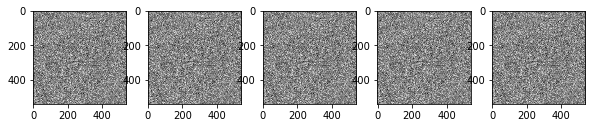

In [148]:
from matplotlib import pyplot as plt
with h5py.File( '/tmp/particles.hdf', 'r' ) as f:
    print( f['particles/images'] )
    fig = plt.figure(figsize=(12, 12))
    for i in range( f['particles/images'].shape[0] ):
        print( "Particle #%s: class %s from %s@%s \n%s " % (i, f['particles/class'][i], f['particles/source_micrograph'][i], f['particles/source_coordinates'][i], f['particles/images'][i]))
        fig.add_subplot( 6, 6, i+1 )
        plt.imshow( f['particles/images'][i], cmap='Greys' )
    plt.show()